In [ ]:
# install and load the necessary packages
install.packages(c('DBI','RPostgres','dplyr'))
library(DBI)
library(RPostgres)
library(dplyr)
library(tidyr)
library(ggplot2)

In [3]:
# create a connection between R and postgres
host <- 'localhost'
port <- '5432'
user <- 'sqlprojects'
dbname <-'HealthCareDB'
password <- 'sqlprojects'
con <- dbConnect(RPostgres::Postgres(),host = host,port = port,user = user,dbname = dbname,password = password)

# retrieve the first ten rows from the patients table
df <-dbGetQuery(con,statement= paste('select * from patient limit 10'))
View(df)

patientid,first_name,last_name,dob,gender,address,phone,email
<int>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>
1,John,Doe,1985-07-15,Male,"123 Elm St, Springfield, IL",5551234567,john.doe01@gmail.com
2,Jane,Smith,1990-03-22,Female,"456 Oak St, Springfield, IL",5552345678,jane.smith91@yahoo.com
3,Alex,Johnson,1995-11-30,Non-Binary,"789 Pine St, Springfield, IL",5553456789,alex.johnson123@outlook.com
4,Michael,Brown,1982-01-10,Male,"101 Maple St, Springfield, IL",5554567890,mike.brown82@hotmail.com
5,Emily,Davis,1993-04-05,Female,"202 Birch St, Springfield, IL",5555678901,emily.davis94@icloud.com
6,Chris,Wilson,1987-08-14,Male,"303 Cedar St, Springfield, IL",5556789012,chris.wilson87@aol.com
7,Taylor,Moore,1991-12-25,Non-Binary,"404 Walnut St, Springfield, IL",5557890123,taylor.moore2020@protonmail.com
8,Jessica,Taylor,1989-09-18,Female,"505 Ash St, Springfield, IL",5558901234,jessica.taylor89@gmail.com
9,David,Anderson,1984-05-02,Male,"606 Pine St, Springfield, IL",5559012345,david.anderson@yahoo.com


In [4]:
# view all the tables within the database and their row counts
tables_query <- "select relname as tablename, n_live_tup as row_count
from pg_stat_user_tables"
dbGetQuery(con, tables_query)

tablename,row_count
<chr>,<int64>
billing,45
patient,50
doctor,11
prescription,53
insurance,50
medical_record,50
lab_test,50
appointment,45


In [5]:
# list the columns within each table
tables <- c('billing','patient','doctor','prescription','insurance','medical_record','lab_test','appointment')
for (i in tables) {
    cols <- dbListFields(con,i)
    cat('Columns for table',i,':',cols,'\n')
}


Columns for table billing : billingid patientid appointmentid billing_date amount status 
Columns for table patient : patientid first_name last_name dob gender address phone email 
Columns for table doctor : doctorid first_name last_name specialty phone_number 
Columns for table prescription : prescriptionid medication_name patientid dosage 
Columns for table insurance : insuranceid insurance_name patientid policy_number expiration_date 
Columns for table medical_record : recordid patientid doctorid visit_date diagnosis 
Columns for table lab_test : testid patientid doctorid test_name order_date test_result 
Columns for table appointment : appointmentid patientid doctorid appointment_date appointment_time status 


In [6]:
# find all the patients that have a 'Scheduled' appointment status, their doctor, appointment time,and date
scheduled_patients = "SELECT a.patientid as patientid,
                      p.first_name ||' '||p.last_name as name,
                      p.dob as date_of_birth,
                      a.status as appointment_status,
                      'Dr.'|| ' '||d.last_name as doctor,
                      d.specialty as specialty,
                      a.appointment_date as appointment_date,
                      TO_CHAR(a.appointment_time,'HH12:MM:SS AM') as appointment_time
                      FROM patient as p INNER JOIN appointment as a
                      on p.patientid = a.patientid
                      INNER JOIN doctor as d on a.doctorid = d.doctorid
                      WHERE a.status = 'Scheduled'";
dbGetQuery(con,scheduled_patients)

patientid,name,date_of_birth,appointment_status,doctor,specialty,appointment_date,appointment_time
<int>,<chr>,<date>,<chr>,<chr>,<chr>,<date>,<chr>
10,Sarah Thomas,1992-07-27,Scheduled,Dr. Johnson,Neurologist,2024-12-29,12:00:00 PM
9,David Anderson,1984-05-02,Scheduled,Dr. Johnson,Neurologist,2025-01-07,07:00:00 AM
1,John Doe,1985-07-15,Scheduled,Dr. Johnson,Neurologist,2024-12-10,09:00:00 AM
9,David Anderson,1984-05-02,Scheduled,Dr. Brown,Pediatrician,2025-01-17,07:00:00 AM
1,John Doe,1985-07-15,Scheduled,Dr. Brown,Pediatrician,2024-12-20,09:00:00 AM
4,Michael Brown,1982-01-10,Scheduled,Dr. Davis,General Practitioner,2024-12-13,08:00:00 AM
1,John Doe,1985-07-15,Scheduled,Dr. Davis,General Practitioner,2025-01-09,09:00:00 AM
4,Michael Brown,1982-01-10,Scheduled,Dr. Miller,Dermatologist,2024-12-23,02:00:00 PM
3,Alex Johnson,1995-11-30,Scheduled,Dr. Miller,Dermatologist,2025-01-01,11:00:00 AM


# A tibble: 4 × 2
  age_group          count
  <chr>            <int64>
1 children               0
2 young_adults          46
3 middleage_adults       4
4 seniors                0


Don't know how to automatically pick scale for object of type <integer64>.
Defaulting to continuous.
Don't know how to automatically pick scale for object of type <integer64>.
Defaulting to continuous.


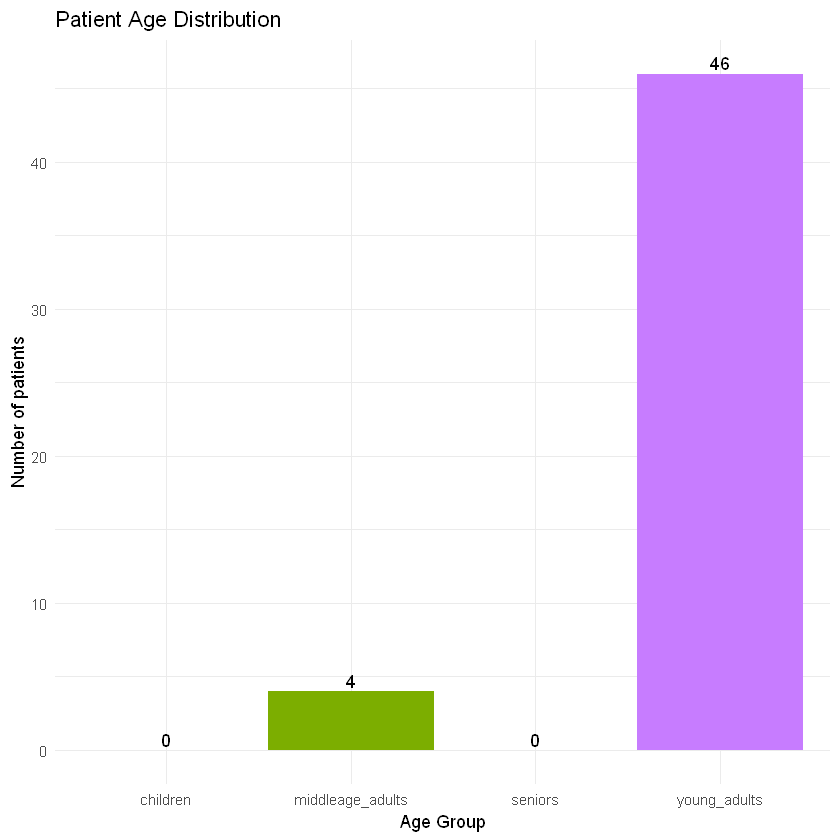

In [7]:
# what is the age distribution of patients
age_query <- "SELECT
              COUNT(CASE WHEN EXTRACT(YEAR FROM AGE(dob)) BETWEEN 0 AND 17 THEN 1 END) AS children,
              COUNT(CASE WHEN EXTRACT(YEAR FROM AGE(dob)) BETWEEN 18 AND 39 THEN 1 END) AS young_adults,
              COUNT(CASE WHEN EXTRACT(YEAR FROM AGE(dob)) BETWEEN 40 AND 64 THEN 1 END) AS middleAge_adults,
              COUNT(CASE WHEN EXTRACT(YEAR FROM AGE(dob)) BETWEEN 65 AND 100 THEN 1 END) AS seniors
              FROM patient
              "
age_distribution <- dbGetQuery(con,age_query)
age_distribution_reshaped <- age_distribution %>%
                                     pivot_longer(cols = everything(),names_to = "age_group",values_to = "count")
print(age_distribution_reshaped)

ggplot(age_distribution_reshaped,aes(x = age_group,y = count,fill = age_group)) +
geom_bar(stat = 'identity') +
geom_text(aes(label = count),vjust = -0.3) +
labs(title ='Patient Age Distribution',y = 'Number of patients',x = 'Age Group') +
theme_minimal() +
theme(legend.position = 'none')




In [8]:
# What is the total revenue by year and insurance
library(scales)
revenue_query <- "SELECT EXTRACT(YEAR FROM billing_date) AS year, insurance_name, SUM(amount) AS total_revenue
                  FROM billing INNER JOIN insurance ON  billing.patientid = insurance.patientid
                  GROUP BY year, insurance_name
                  ORDER BY year ASC, total_revenue DESC"
revenue <- dbGetQuery(con,revenue_query)
revenue$total_revenue <- dollar(revenue$total_revenue)
print(revenue)

   year    insurance_name total_revenue
1  2024 MedicareAdvantage       $300.00
2  2024        LifeSecure       $300.00
3  2024          MedTrust       $280.00
4  2024      GlobalHealth       $275.00
5  2024      GuardianCare       $250.00
6  2024        BlueShield       $250.00
7  2024        FamilyCare       $250.00
8  2024         TotalCare       $240.00
9  2024          FlexCare       $225.00
10 2024        SecureLife       $225.00
11 2024      MediCarePlus       $220.00
12 2024        UnitedCare       $220.00
13 2024          LifeCare       $210.00
14 2024        HealthPlus       $210.00
15 2024      ChoiceHealth       $210.00
16 2024      MedicarePlus       $200.00
17 2024           MedCare       $200.00
18 2024         CareFirst       $190.00
19 2024      HealthChoice       $190.00
20 2024          WellPath       $185.00
21 2024         BlueCross       $180.00
22 2024         CignaPlus       $180.00
23 2024       OptimumCare       $175.00
24 2024       PrimeHealth       $175.00


In [9]:
# what are the top 5 used insurance by revenue and year
# DENSE_RANK() was used to allow ties between rows
library(scales)

top_5_query <- "with ranked_insurance AS (
        SELECT EXTRACT(YEAR FROM billing_date) AS year, insurance_name, amount,
        DENSE_RANK() OVER(PARTITION BY EXTRACT(YEAR FROM billing_date) ORDER BY amount DESC) AS rank
        FROM billing AS b INNER JOIN insurance AS i ON b.patientid = i.patientid)

        SELECT year, insurance_name, amount
        FROM ranked_insurance
        WHERE rank <= 5
        GROUP BY year, insurance_name, amount
        ORDER BY year,amount DESC"
top_5_table <- dbGetQuery(con,top_5_query)
top_5_table$amount <- dollar(top_5_table$amount)
print(top_5_table)



   year    insurance_name amount
1  2024        LifeSecure   $300
2  2024 MedicareAdvantage   $300
3  2024          MedTrust   $280
4  2024      GlobalHealth   $275
5  2024        BlueShield   $250
6  2024        FamilyCare   $250
7  2024      GuardianCare   $250
8  2024         TotalCare   $240
9  2025           AllCare   $270
10 2025    LifeSecurePlus   $250
11 2025       VitalHealth   $250
12 2025      WellnessCare   $240
13 2025        SecurePlus   $230
14 2025       SmartHealth   $220
15 2025         TrustCare   $220


In [10]:
# number of patients seen by or scheduled with each doctor
patient_doc_query <- "SELECT a.doctorid, 'Dr.'||' '|| last_name AS doctor, COUNT(patientid) AS patients_evaluated
                      FROM doctor AS d INNER JOIN appointment AS a
                      ON d.doctorid = a.doctorid
                      WHERE status ILIKE 'Completed' OR status ILIKE 'Scheduled'
                      GROUP BY a.doctorid, doctor
                      ORDER BY patients_evaluated DESC"
result <- dbGetQuery(con,patient_doc_query)
print(result)


   doctorid       doctor patients_evaluated
1        10 Dr. Anderson                  5
2         6   Dr. Miller                  5
3         5    Dr. Davis                  4
4         8    Dr. Moore                  4
5         3    Dr. Brown                  4
6         9   Dr. Taylor                  3
7         2  Dr. Johnson                  3
8         1    Dr. Smith                  3
9         7   Dr. Wilson                  3
10        4 Dr. Williams                  1


In [11]:
# TOP 10 common diagnosis
diagnosis_query <- "SELECT diagnosis, COUNT(patientid) as count
                    FROM medical_record
                    GROUP BY diagnosis
                    ORDER BY count DESC 
                    LIMIT 10"
diagn_result <- dbGetQuery(con,diagnosis_query)
print(diagn_result)


                                diagnosis count
1                Chronic Fatigue Syndrome     2
2  Gastroesophageal Reflux Disease (GERD)     1
3                           Liver Disease     1
4             Upper Respiratory Infection     1
5                         Hyperthyroidism     1
6                            Tuberculosis     1
7                  Chronic Kidney Disease     1
8                               Cirrhosis     1
9                 Obstructive Sleep Apnea     1
10                             Depression     1
